<img src="https://www.rochester.edu/assets/images/ur-logo.svg">

# <center>[CSC 249/449: Machine Vision](https://www.cs.rochester.edu/~cxu22/t/249F20/)</center>

## Homework Submission
After completed the homework notebook. 
- Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`, as well as your NetID below.
- `Kernel`$\rightarrow$ `Restart & Run All` (in the menubar).
- You can generated zip file using following command:
    ```python
    NetID=''
    make_submission(NetID)
    ```
- Double-check **generated zip file**, text, math, code, outputs, figures. Re-run if needed.
- Sumbit the zip file via blackboard.
- 1% deduction of late assignment total score per hour passing the deadline.
---------


## Part 3. RNN
----
### Problem 2.1 Sequence modeling with LSTM

In this Problem, we will try to do time series forecasting with our LSTM cell for on coronavirus cases.


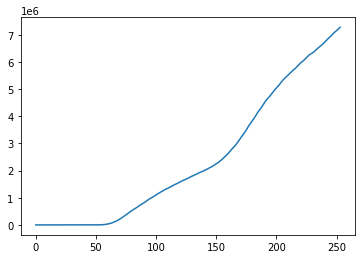

In [1]:
from cs249 import *
df = pd.read_csv('time_series_covid19_confirmed_US.csv')
data=[int(v) for k,v in df.iloc[:, 11:].sum().to_dict().items()]
plt.plot(range(len(data)),data)

#### a. perpare dataset

In order to capture the local sequence pattern, we will slice data as sequences `[i,i+seq_length]` and the next data as predicted data. In other word, we are using a short period to predict one step further.

In [2]:
# slice data with seq_length and y 
def get_sequences(data, seq_length):
    list = []
    pred = []
    i = 0
    while i < len(data)-seq_length:
        list.append(data[i:i+seq_length])
        if i+seq_length < len(data):
            pred.append(data[i+seq_length])
        i = i + 1
    return np.asarray(list), np.asarray(pred)

In [3]:
seq_length = 4
x,y=[d.unsqueeze(-1).float() for d in list(map(torch.from_numpy, get_sequences(data, seq_length)))]
x/=x.max()
y/=y.max()
assert(x.shape[0]+seq_length==len(data)), "checkout dimension" 

#### b. implement LSTM cell
In this part, you will implement your LSTM unit based on the following formulations:
$$        
\begin{array}{ll} \\
    i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
    f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\ 
    g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
    o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
    c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
    h_t = o_t \odot \tanh(c_t) \\
\end{array}
$$

In [4]:
import math
import torch
import torch.nn as nn
class LSTMCell(nn.Module):
    """
    LSTM cell implementation
    Given an input x at time step t, and hidden and cell states: hidden = (h_(t-1), c_(t-1)),
    you will implement a LSTM unit to compute and return (h_t, c_t)
    hints: consider use linear layers to implement the several matrices W_* 
    Note: you just need to implement a one-layer LSTM unit
    """
    # f_t: forget gate layer, i_t: input gate layer, g_t: input modulation gate layer, o_t & h_t: output gate, 
    # update cell state: c_t
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # forget gate components
        self.linear_forget_w1 = nn.Linear(self.input_size, self.hidden_size, bias=True)
        self.linear_forget_r1 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.sigmoid_forget = nn.Sigmoid()

        # input gate components
        self.linear_gate_w2 = nn.Linear(self.input_size, self.hidden_size, bias=True)
        self.linear_gate_r2 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.sigmoid_gate = nn.Sigmoid()

        # cell memory components
        self.linear_gate_w3 = nn.Linear(self.input_size, self.hidden_size, bias=True)
        self.linear_gate_r3 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.activation_gate = nn.Tanh()

        # out gate components
        self.linear_gate_w4 = nn.Linear(self.input_size, self.hidden_size, bias=True)
        self.linear_gate_r4 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.sigmoid_hidden_out = nn.Sigmoid()

        self.activation_final = nn.Tanh()

    def forget(self, x, h):
        x = self.linear_forget_w1(x)
        h = self.linear_forget_r1(h)
        return self.sigmoid_forget(x + h)

    def input_gate(self, x, h):

        # Equation 1. input gate
        x_temp = self.linear_gate_w2(x)
        h_temp = self.linear_gate_r2(h)
        i = self.sigmoid_gate(x_temp + h_temp)
        return i

    def cell_memory_gate(self, i, f, x, h, c_prev):
        x = self.linear_gate_w3(x)
        h = self.linear_gate_r3(h)

        # new information part that will be injected in the new context
        k = self.activation_gate(x + h)
        g = k * i

        # forget old context/cell info
        c = f * c_prev
        # learn new context/cell info
        c_next = g + c
        return c_next

    def out_gate(self, x, h):
        x = self.linear_gate_w4(x)
        h = self.linear_gate_r4(h)
        return self.sigmoid_hidden_out(x + h)

    def forward(self, x, tuple_in):
        (h, c_prev) = tuple_in
        # input gate
        i = self.input_gate(x, h)

        # forget gate
        f = self.forget(x, h)

        # updating the cell memory
        c_next = self.cell_memory_gate(i, f, x, h,c_prev)

        # calculate the main output gate
        o = self.out_gate(x, h)

        # produce next hidden output
        h_next = o * self.activation_final(c_next)

        return h_next, c_next

In [5]:
import math
import torch
import torch.nn as nn

class LSTM(nn.Module):
    """
    LSTM cell implementation
    LSTM is used to handle sequence and LSTMCell is responsible for computing one time step forward
    """
    def __init__(self, input_size, hidden_size, seq_len):
        super(LSTM, self).__init__()
        
        # The input size
        self.input_size = input_size
        
        # Dimension of weight vectors
        self.hidden_dim = hidden_size
        
        # Number of time steps
        self.sequence_len = seq_len
        
        # Initialize LSTM Cell
        self.lstm_cell = LSTMCell(self.input_size, self.hidden_dim)
        
            
    def forward(self, x, tuple_in):
        # Creation of cell state and hidden state
        (hidden_state, cell_state) = tuple_in

        # Weights initialization
        torch.nn.init.xavier_normal_(hidden_state)
        torch.nn.init.xavier_normal_(cell_state)

        hidden_state, cell_state = self.lstm_cell(x, (hidden_state, cell_state))
    
        return hidden_state

#### b.  define network
- We will define our `predictor` as one LSTM followed with one-layer MLP.
- `predictor` will contain init hidden states for LSTM.
- You will have to implement a `reset_hidden_state` function to reset the hidden states at the begining at each epoch.
- Test your implementation by replacing the nn.LSTM from Pytorch with the nn.LSTM.

In [6]:
class COVIDPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len):
        super(COVIDPredictor, self).__init__()
        #self.LSTM = nn.LSTM(n_features, 1, seq_len)
        self.LSTM = LSTM(n_features, 1, seq_len)
        self.lin1 = nn.Linear(1, n_hidden)
        self.lin2 = nn.Linear(n_hidden, 1)
        self.num_layers = n_features
        self.batch_size = seq_len
        self.hidden_dim = n_hidden
        
    def init_hidden(self):
        h0 = torch.randn(250, 4, 1)
        c0 = torch.randn(250, 4, 1)
        return h0,c0
    
    def forward(self, x): 
        (h0, c0) = self.init_hidden()
        out = self.LSTM(x,(h0, c0))
        out = torch.nn.functional.leaky_relu(self.lin1(out))
        out = self.lin2(out)
        return out

#### b.  Training

We don't have test data to verify the performance, however you need to plot the traning loss to see whether it can converage or not. 
You are free to change the parameter for `n_hidder` ,optimiser parameter and epoch number to have a better loss curver.

In [7]:
model = COVIDPredictor(n_features=1,n_hidden=500,seq_len=seq_length)
loss_fn = torch.nn.MSELoss(reduction='sum')
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 60
for t in range(num_epochs):  
    model.zero_grad()
    optimiser.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred[:,3,:], y)
    print('Epoch {}: train loss: {}'.format(t, loss.item()))
    loss.backward()
    optimiser.step()

Epoch 0: train loss: 32.12430191040039
Epoch 1: train loss: 26.719192504882812
Epoch 2: train loss: 27.890047073364258
Epoch 3: train loss: 29.03240203857422
Epoch 4: train loss: 27.949506759643555
Epoch 5: train loss: 26.43635368347168
Epoch 6: train loss: 25.638465881347656
Epoch 7: train loss: 25.91195297241211
Epoch 8: train loss: 26.347803115844727
Epoch 9: train loss: 26.203737258911133
Epoch 10: train loss: 25.52824592590332
Epoch 11: train loss: 24.669422149658203
Epoch 12: train loss: 24.306617736816406
Epoch 13: train loss: 24.183090209960938
Epoch 14: train loss: 24.438783645629883
Epoch 15: train loss: 24.22360610961914
Epoch 16: train loss: 23.809432983398438
Epoch 17: train loss: 23.09742546081543
Epoch 18: train loss: 22.899707794189453
Epoch 19: train loss: 22.924985885620117
Epoch 20: train loss: 22.578594207763672
Epoch 21: train loss: 22.671125411987305
Epoch 22: train loss: 21.959182739257812
Epoch 23: train loss: 21.547178268432617
Epoch 24: train loss: 21.22895050